In [1]:
# 0. (Optional in Colab) - install required packages
# In Colab you can uncomment the next line if libraries are missing:
# !pip install pandas scikit-learn

# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import numpy as np

# 2. Load dataset
# Replace the path if needed. This assumes columns: label, text
df = pd.read_csv("spam.csv", encoding="latin-1")        # many spam datasets use latin-1
# Keep only first two columns if extra junk columns exist (common with some spam.csv files)
df = df.iloc[:, :2]
df.columns = ["label", "text"]

# Quick view (optional)
print("Dataset size:", len(df))
print(df["label"].value_counts())

# 3. Preprocess labels
df = df.dropna(subset=["text", "label"])   # drop rows with missing text/label
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})
# If mapping results in NaNs (different label names), adjust mapping accordingly.

# 4. Train / test split
X = df["text"].astype(str)
y = df["label_num"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Text -> TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 6. Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_tfidf, y_train)   # fits continuous outputs

# 7. Predict (continuous scores) and convert to classes by thresholding at 0.5
y_pred_cont = lr.predict(X_test_tfidf)        # continuous predictions (can be <0 or >1)
# Clip predictions to [0,1] only for ROC/AUC sensibility (optional)
y_pred_cont_clipped = np.clip(y_pred_cont, 0, 1)
y_pred_class = (y_pred_cont_clipped >= 0.5).astype(int)

# 8. Evaluation metrics
acc = accuracy_score(y_test, y_pred_class)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_class, average="binary")
cm = confusion_matrix(y_test, y_pred_class)

# For ROC AUC use continuous scores
try:
    auc = roc_auc_score(y_test, y_pred_cont_clipped)
except ValueError:
    auc = None

print("\n--- Evaluation (Linear Regression used as classifier) ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
if auc is not None:
    print(f"ROC AUC: {auc:.4f}")
print("\nConfusion Matrix (rows=true, cols=predicted):")
print(cm)

# 9. (Optional) Show some example predictions
def show_examples(n=5):
    idxs = np.random.choice(range(X_test.shape[0]), size=n, replace=False)
    for i in idxs:
        txt = X_test.iloc[i]
        true = y_test.iloc[i]
        score = float(y_pred_cont_clipped[i])
        pred = "SPAM" if score >= 0.5 else "HAM"
        print("-----")
        print("Text (truncated):", txt[:180].replace("\n", " "))
        print("True:", "SPAM" if true==1 else "HAM", "| Predicted:", pred, f"| score={score:.3f}")

show_examples(6)

# 10. (Optional) Save model and vectorizer for later use
import joblib
joblib.dump(lr, "linear_regressor_spam_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("\nSaved model to 'linear_regressor_spam_model.joblib' and vectorizer to 'tfidf_vectorizer.joblib'")

# 11. Helper function to predict a single new email
def predict_email_text(text):
    v = tfidf.transform([text])
    score = lr.predict(v)[0]
    score = float(np.clip(score, 0, 1))
    label = "SPAM" if score >= 0.5 else "HAM"
    return {"label": label, "score": score}

# Example
sample = "Congratulations! You've been selected to win a $1000 gift card. Click here."
print("\nSample prediction:", predict_email_text(sample))


Dataset size: 5572
label
ham     4825
spam     747
Name: count, dtype: int64

--- Evaluation (Linear Regression used as classifier) ---
Accuracy: 0.9731
Precision: 0.9407
Recall: 0.8523
F1-score: 0.8944
ROC AUC: 0.9846

Confusion Matrix (rows=true, cols=predicted):
[[958   8]
 [ 22 127]]
-----
Text (truncated): I'm going out to buy mum's present ar.
True: HAM | Predicted: HAM | score=0.000
-----
Text (truncated): First has she gained more than  &lt;#&gt; kg since she took in. Second has she done the blood sugar tests. If she has and its ok and her blood pressure is within normal limits then
True: HAM | Predicted: HAM | score=0.425
-----
Text (truncated): Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.
True: HAM | Predicted: HAM | score=0.008
-----
Text (truncated): Ok then u tell me wat time u coming later lor.
True: HAM | Predicted: HAM | score=0.000
-----
Text (truncated): Hey sorry I didntgive ya a a bellea

Dataset Loaded Successfully
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

===== QUALITATIVE ANALYSIS =====

Column Data Types:
label    object
text     object
dtype: object

Unique Labels:
['ham' 'spam']

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Example SPAM Messages:
   label                                               text
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...

Example HAM (Not Spam) 

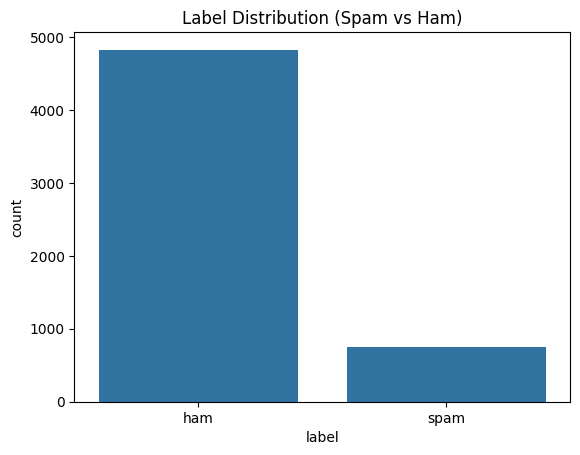

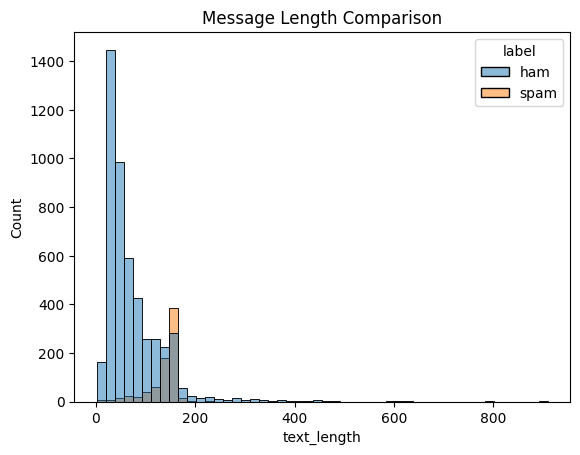


===== QUANTITATIVE ANALYSIS =====

Basic Statistics for Message Length:
count    5572.000000
mean       80.494616
std        59.998745
min         2.000000
25%        36.000000
50%        61.000000
75%       122.000000
max       910.000000
Name: text_length, dtype: float64

Correlation Matrix:
             text_length  label_num
text_length     1.000000   0.379988
label_num       0.379988   1.000000


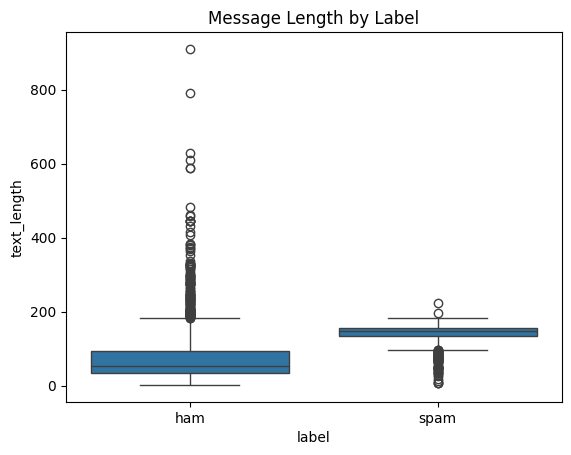


Train/Test Size:
Train: 4457 Test: 1115

T-Test: Comparing Message Lengths (SPAM vs HAM)
T-Statistic: 30.65916138772345
P-Value: 6.844901884258752e-191
=> Difference IS statistically significant


In [2]:
# ============================================
# QUALITATIVE + QUANTITATIVE DATA ANALYSIS
# ============================================

# Install libraries (only needed in Colab)
# !pip install pandas numpy seaborn matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 1. LOAD DATASET
# ==========================
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.iloc[:, :2]      # keep only 2 columns (spam datasets usually have extra)
df.columns = ["label", "text"]

print("Dataset Loaded Successfully")
print(df.head())

# ==================================================
# 2. QUALITATIVE ANALYSIS (NON-NUMERIC / TEXT)
# ==================================================

print("\n===== QUALITATIVE ANALYSIS =====")

# Column types
print("\nColumn Data Types:")
print(df.dtypes)

# Unique values in label column
print("\nUnique Labels:")
print(df["label"].unique())

# Count of each label
print("\nLabel Distribution:")
print(df["label"].value_counts())

# Sample spam examples
print("\nExample SPAM Messages:")
print(df[df["label"] == "spam"].head(5))

# Sample ham examples
print("\nExample HAM (Not Spam) Messages:")
print(df[df["label"] == "ham"].head(5))

# Distribution plot
sns.countplot(x="label", data=df)
plt.title("Label Distribution (Spam vs Ham)")
plt.show()

# Message length feature (qualitative insight)
df["text_length"] = df["text"].apply(len)

sns.histplot(data=df, x="text_length", hue="label", bins=50)
plt.title("Message Length Comparison")
plt.show()

# ==================================================
# 3. QUANTITATIVE ANALYSIS (NUMERIC MEASUREMENTS)
# ==================================================

print("\n===== QUANTITATIVE ANALYSIS =====")

# Convert label to numeric
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

# Basic stats
print("\nBasic Statistics for Message Length:")
print(df["text_length"].describe())

# Correlation between text_length and label
print("\nCorrelation Matrix:")
print(df[["text_length", "label_num"]].corr())

# Boxplot for length difference
sns.boxplot(x="label", y="text_length", data=df)
plt.title("Message Length by Label")
plt.show()

# --------------------------
# 4. Train/Test Split (Optional for Analysis)
# --------------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df["text_length"], df["label_num"], test_size=0.2, random_state=42
)

print("\nTrain/Test Size:")
print("Train:", len(X_train), "Test:", len(X_test))

# ==================================================
# 5. Quantitative Statistical Tests (Optional)
# ==================================================

from scipy.stats import ttest_ind

# T-test: Are spam messages longer than ham messages?
spam_length = df[df["label_num"] == 1]["text_length"]
ham_length = df[df["label_num"] == 0]["text_length"]

t_stat, p_value = ttest_ind(spam_length, ham_length)

print("\nT-Test: Comparing Message Lengths (SPAM vs HAM)")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("=> Difference IS statistically significant")
else:
    print("=> Difference is NOT statistically significant")



In [3]:
# =====================================================
# 1. INSTALL LIBRARIES (Run only in Google Colab)
# =====================================================
# !pip install pandas scikit-learn tensorflow

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# =====================================================
# 2. LOAD DATASET
# =====================================================
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.iloc[:, :2]   # keep first 2 columns only
df.columns = ["label", "text"]

print(df.head())

# =====================================================
# 3. PREPROCESSING
# =====================================================

# convert labels into numeric 0/1
label_encoder = LabelEncoder()
df["label_num"] = label_encoder.fit_transform(df["label"])
# spam = 1, ham = 0

X = df["text"].astype(str)
y = df["label_num"].astype(int)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# 4. TF-IDF VECTORIZATION
# =====================================================
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print("TF-IDF shape:", X_train_tfidf.shape)

# =====================================================
# 5. BUILD A NEURAL NETWORK MODEL (TRAINED WITH EPOCHS)
# =====================================================

model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # sigmoid for binary classification
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# =====================================================
# 6. TRAIN THE MODEL — WITH EPOCHS
# =====================================================

history = model.fit(
    X_train_tfidf,
    y_train,
    epochs=10,           # 🔥 YOU CAN INCREASE EPOCHS HERE
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# =====================================================
# 7. EVALUATE MODEL
# =====================================================

loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print("\nTest Accuracy:", accuracy)

# =====================================================
# 8. PREDICT CUSTOM EMAIL
# =====================================================

def predict_email(text):
    v = tfidf.transform([text]).toarray()
    prediction = model.predict(v)[0][0]
    return "SPAM" if prediction >= 0.5 else "HAM"

sample = "Congratulations! You have won a $1000 gift card, click here!"
print("\nSample Prediction:", predict_email(sample))


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
TF-IDF shape: (4457, 5000)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,097 (10.27 MB)

 Trainable params: 2,692,097 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8448 - loss: 0.3774 - val_accuracy: 0.9664 - val_loss: 0.1378
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9879 - loss: 0.0573 - val_accuracy: 0.9843 - val_loss: 0.0577
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9964 - loss: 0.0118 - val_accuracy: 0.9843 - val_loss: 0.0559
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.9821 - val_loss: 0.0593
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9821 - val_loss: 0.0648
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9843 - val_loss: 0.0705
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9999 - loss: 7.9517e-04 - val_accuracy: 0.9843 - val_loss: 0.0662
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 1.0000 - loss: 4.5092e-04 -